<a href="https://colab.research.google.com/github/TuckerArrants/computer-vision/blob/master/melanoma-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Melanoma Classification with TPUs

**This notebook is largely just a repurposing of my kernel for the Flowers competition, adapted for binary classification and with competition specific metrics. I also added course dropout augmentation, taken from Chris Deotte's [starter](https://www.kaggle.com/cdeotte/tfrecord-experiments-upsample-and-coarse-dropout) and removed CutMix and MixUp since it is hard to implement in this competition (more [here](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/160784)):**

In [1]:
#the basics
from matplotlib import pyplot as plt
import math, os, re, gc
import numpy as np, pandas as pd, seaborn as sns

#deep learning basics
import tensorflow as tf
import tensorflow.keras.backend as K

#get current TensorFlow version fo
print("Currently using Tensorflow version " + tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Currently using Tensorflow version 2.3.0


# I. Configuration

**To take advantage of TPUs, we have to do some extra work. For the uninitiated, [this](http://www.tensorflow.org/guide/tpu) is an excellent place to start. We start by checking to see if TensorFlow is using a TPU or not - if it isn't, we set the 'strategy' to its default, which works on CPU and a single GPU, though we will definitely need to use the TPU for the current parameter setups of this notebook**

In [2]:
#choose device
DEVICE = 'TPU'

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.60.63.234:8470
initializing  TPU ...
INFO:tensorflow:Initializing the TPU system: grpc://10.60.63.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.60.63.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


In [3]:
#for reproducibility
SEED = 34 

#select image size             
IMAGE_SIZE = [128, 128]               

#how many training samples we want going to TPUs 
BATCH_SIZE = 32 * REPLICAS 

#how long are we training for?
EPOCHS = 12

#how many folds we will use to train our model on
FOLDS = 5

#how many TTA steps to apply
#set to 0 for no TTA
TTA = 10   

#to see training progress or not
VERBOSE = 2

**TPUs read data directly from Google Cloud Storage (GCS), so we actually need to copy our dataset to a GCS 'bucket' that is near or 'co-located' with the TPU. The below chunk of code accomplishes this using the handy kaggle_datasets:** 

In [4]:
GCS_PATH = 'gs://kds-7b5a61673b55b50c8616d7df218b1a1b8e2c2e2a3384ea294b438bd8'

In [5]:
#can use this path in Google Colabs if you want to host notebook else where
print(GCS_PATH)

gs://kds-7b5a61673b55b50c8616d7df218b1a1b8e2c2e2a3384ea294b438bd8


**Now we need to create some functions that allow us to extract information from these `TFRecords`. We will create functions that read the image and label from the `TFRecords`. For more about this, see [here](http://www.tensorflow.org/tutorials/load_data/tfrecord)**

**We can also perform some easy augmentations to be used during training and also for test time augmentation. For a quick reference on using `tf.image` to perform image augmentation, see [this](http://www.tensorflow.org/tutorials/images/data_augmentation)**

**Note: to achieve peak performance, we can use a pipeline that 'prefetches' data for the next step before the current step has finished using `tf.data`. You can learn more [here](http://www.tensorflow.org/guide/data_performance)**

In [6]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name=True):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

 
def prepare_image(img, course_drop=False, mat_aug = False, dim=IMAGE_SIZE[0], droprate=.7, dropct=8, dropsize=.2):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if course_drop:
        if (droprate!=0)&(dropct!=0)&(dropsize!=0): 
            img = dropout(img, DIM=dim, PROBABILITY=droprate, CT=dropct, SZ=dropsize)
        img = tf.image.random_flip_left_right(img)
        
        #some other easy transformations we can apply
        #img = tf.image.random_hue(img, 0.01)
        #img = tf.image.random_saturation(img, 0.7, 1.3)
        #img = tf.image.random_contrast(img, 0.8, 1.2)
        #img = tf.image.random_brightness(img, 0.1)
        
    if mat_aug: img = transform(img,DIM=dim)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [7]:
#define pre fetching strategy
AUTO = tf.data.experimental.AUTOTUNE

#use tf.io.gfile.glob to find our training and test files from GCS bucket
train_files = np.array(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec'))
test_files  = np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec'))
    
#show item counts
NUM_TRAINING_IMAGES = int( count_data_items(train_files) * (FOLDS-1.)/FOLDS )
NUM_VALIDATION_IMAGES = int( count_data_items(train_files) * (1./FOLDS) )
NUM_TEST_IMAGES = count_data_items(test_files)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 26153 training images, 6538 validation images, 10982 unlabeled test images


In [8]:
def get_dataset(files, course_drop = False, shuffle = False, repeat = False, 
                labeled = True, return_image_names=True, batch_size=BATCH_SIZE, dim=IMAGE_SIZE[0],
                mat_aug = False, droprate=.8, dropct=8, dropsize=.2):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*2) #if too large causes OOM in GPU CPU
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)   
        
    ds = ds.map(lambda img, imgname_or_label: (
                prepare_image(img, course_drop=course_drop, dim=dim, 
                              mat_aug=mat_aug, droprate=droprate, dropct=dropct, dropsize=dropsize), 
                imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTO)
    return ds

# II. Visualization

**Now that we have dealt with all the configuring required to use TPUs, we can extract our images from the TPU and finally get a look at our data:**

In [9]:
#define classes for labeling purposes
classes = ['benign', 'malignant']

**Define some helper functions to plot our melanoma images:**

In [10]:
#numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    #binary strings are image IDs
    if numpy_labels.dtype == object:
        numpy_labels = [None for _ in enumerate(numpy_images)]
    #If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return classes[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(classes[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                classes[correct_label] if not correct else ''), correct

def display_one_image(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    #auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    #size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    #display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else classes[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_image(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #get optimal spacing
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [11]:
#first look at training dataset
training_dataset = get_dataset(train_files, labeled = True, course_drop = False,
                               mat_aug = False, shuffle = True, repeat = True)
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

In [12]:
#first look at test dataset
test_dataset = get_dataset(test_files, labeled = False, shuffle = True, repeat = False)
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

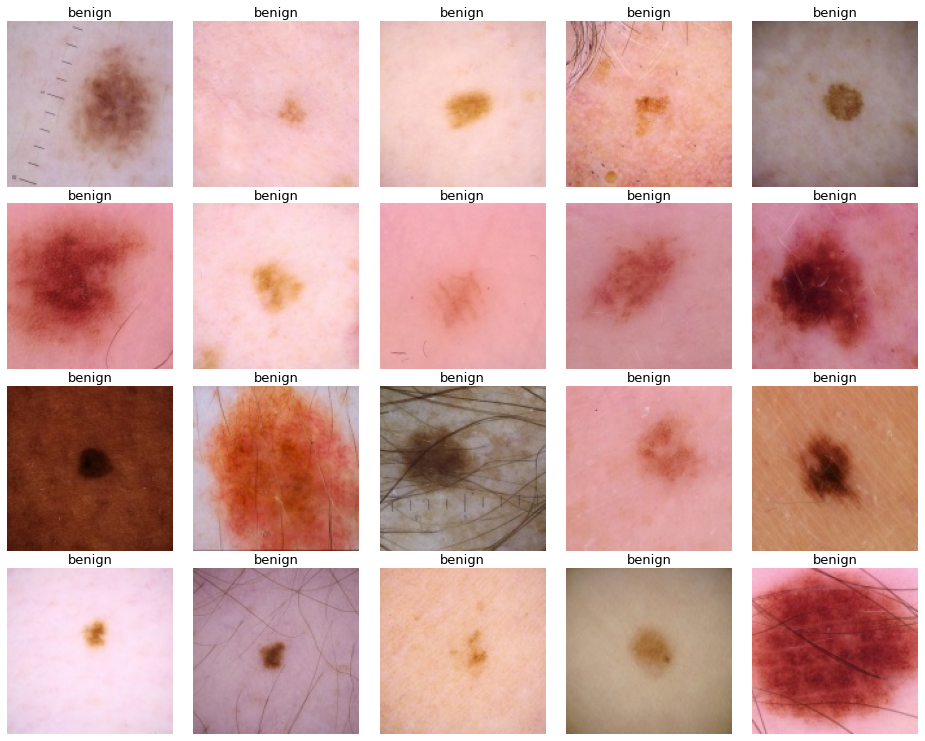

In [13]:
#view batch of images from train
display_batch_of_images(next(train_batch))
#you can run this cell again and it will load a new batch

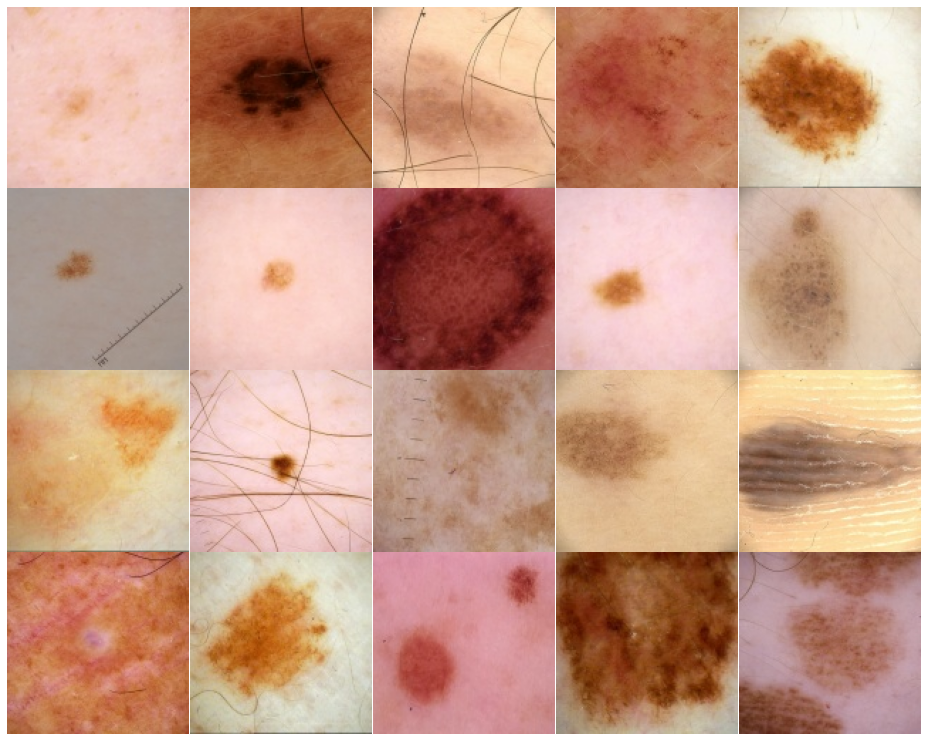

In [14]:
#view batch of images from test
display_batch_of_images(next(test_batch))
#you can run this cell again and it will load a new batch

# III. Augmentation

**Note: the following augmentation implementations are taken from (4X Kaggle Grandmaster) [Chris Deotte](https://www.kaggle.com/cdeotte)'s notebook, which can be found [here](https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords/data) and [here](https://www.kaggle.com/cdeotte/tfrecord-experiments-upsample-and-coarse-dropout)**

### Rotation, Shift, Zoom, Shear

In [15]:
ROT_ = 180.0; SHR_ = 2.0
HZOOM_ = 8.0; WZOOM_ = 8.0
HSHIFT_ = 8.0; WSHIFT_ = 8.0

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):

    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    

    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))

In [16]:
def transform(image, DIM=256):    
    
    XDIM = DIM%2 
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )

    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
              
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

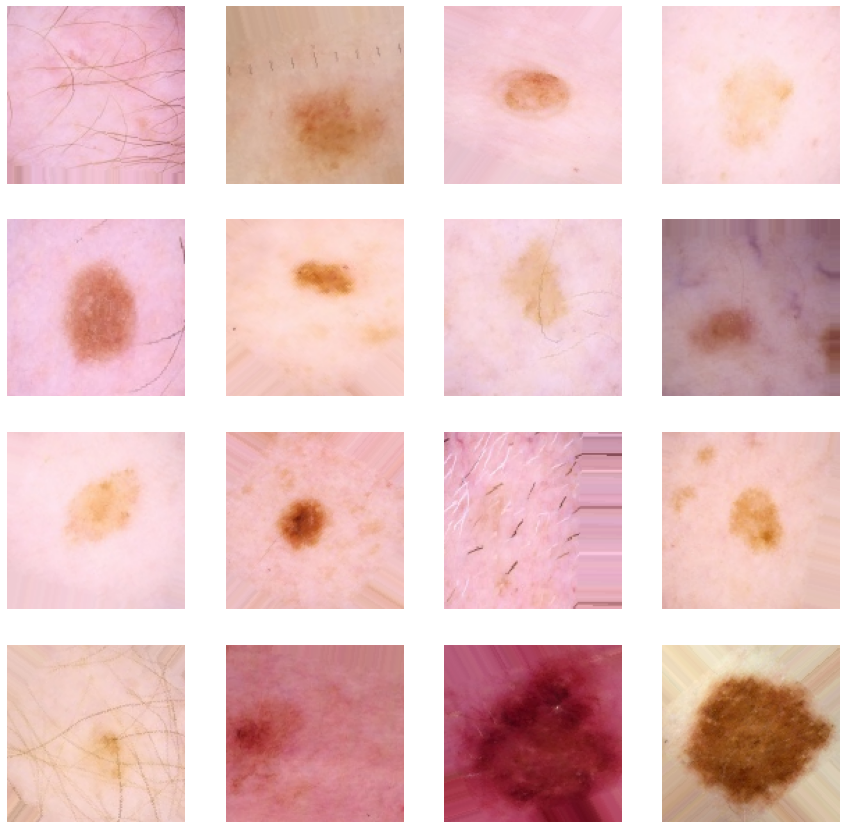

In [17]:
#view augmentation
row = 4; col = 4;
row = min(row,BATCH_SIZE//col)
all_elements = get_dataset(train_files, labeled = True, mat_aug = True,
                           course_drop = False, shuffle = True, repeat = True)

for (img,label) in all_elements:
    plt.figure(figsize=(15,15))
    for j in range(16):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

## Coarse Dropout

**Using MixUp/CutMix for this problem is a bit tricky as there are only two classes and only about 1.8% of samples are malignant. You can read more about the challenges [here](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/160784) as explained by [Roman](https://www.kaggle.com/nroman)**

**We can instead resort to coarse dropout augmentation for online augmentation:**

In [18]:
def dropout(image, DIM=256, PROBABILITY = 0.7, CT = 8, SZ = 0.2):
    
    prob = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (prob==0)|(CT==0)|(SZ==0): return image
    
    for k in range(CT):

        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        WIDTH = tf.cast( SZ*DIM,tf.int32) * prob
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)

        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3]) 
        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)
            
    image = tf.reshape(image,[DIM,DIM,3])
    return image

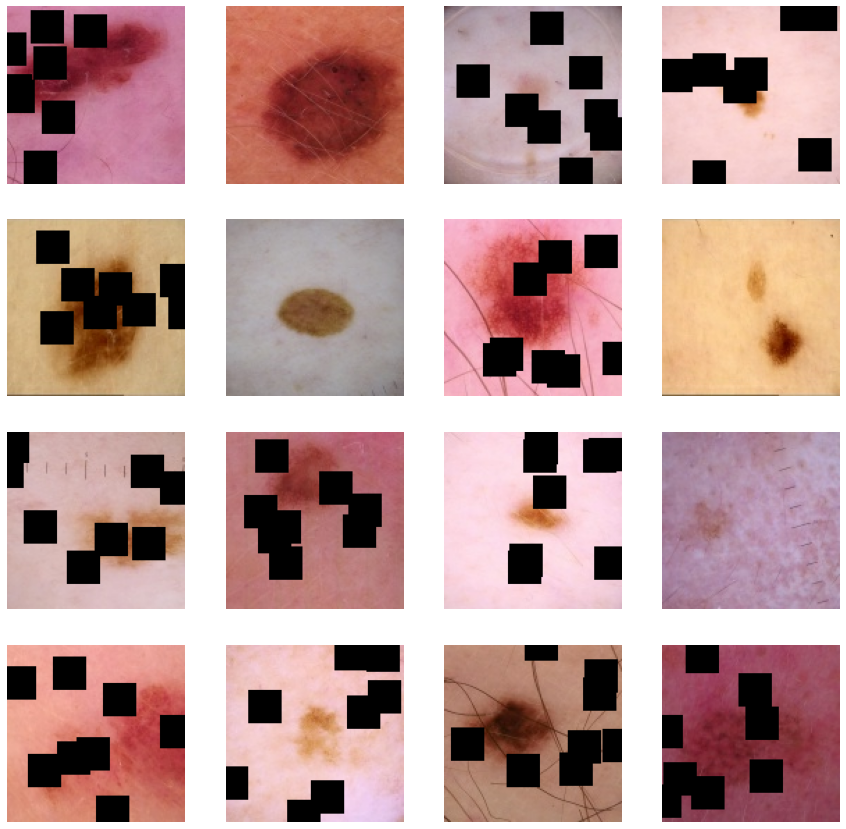

In [19]:
#view what course dropout looks like
row = 4; col = 4;
row = min(row,BATCH_SIZE//col)
all_elements = get_dataset(train_files, labeled = True,
                           course_drop = True, shuffle = True, repeat = True)

for (img,label) in all_elements:
    plt.figure(figsize=(15,15))
    for j in range(16):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

# IV. Model Training

**Now, it will take far too much time for us to train a model ourselves to learn the optimal weights for classifying our images, so we will instead import a model that has already been pre-trained on ImageNet: a large labeled dataset of real-world images**

**We will be importing several popular pre-trained models. For a list of all the pre-trained models that can be imported with `tf.keras`, see [here](https://keras.io/api/applications/)**

Learning rate schedule: 5e-06 to 4e-05 to 1.79e-05


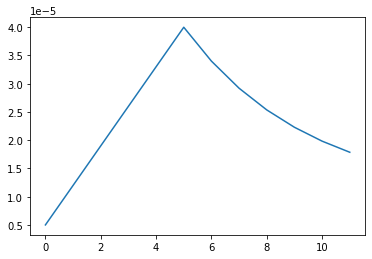

In [20]:
#define epoch parameters
STEPS_PER_EPOCH = count_data_items(train_files) // BATCH_SIZE

#define learning rate parameters
LR_START = 5e-6
LR_MAX = 5e-6 * strategy.num_replicas_in_sync
LR_MIN = 1e-5
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_DECAY = .8

#define ramp up and decay
def lr_schedule(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose = True)

#visualize learning rate schedule
rng = [i for i in range(EPOCHS)]
y = [lr_schedule(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

**If you decide to use an EfficientNet model for your final model, you need to install something as it is not yet supported by `keras.applications`. There is another weight option for EffNets to consider that outperforms Imagenet weights called 'Noisy Student' that you can read about [here](https://arxiv.org/abs/1911.04252). For more on EffNets in general, read [this](https://arxiv.org/pdf/1905.11946.pdf)**

In [21]:
#import DenseNet201, Xception, InceptionV3, and InceptionResNetV2
from tensorflow.keras.applications import DenseNet201, Xception, InceptionV3, InceptionResNetV2

#requirements to use EfficientNet(s)
!pip install -q efficientnet
import efficientnet.tfkeras as efn

In [22]:
#helper function to create our model
def get_DenseNet201():
    with strategy.scope():
        dnet = DenseNet201(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        dnet.trainable = True
        model = tf.keras.Sequential([
            dnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation = 'sigmoid')
        ])
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05) 
    model.compile(optimizer = opt,loss = loss,metrics = ['AUC'])
    return model


#create Xception model
def get_Xception():
    with strategy.scope():
        xception = Xception(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        xception.trainable = True
        model = tf.keras.Sequential([
            xception,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation = 'sigmoid')
        ])
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05) 
    model.compile(optimizer = opt,loss = loss,metrics = ['AUC'])
    return model

#create Inception model
def get_InceptionV3():
    with strategy.scope():
        inception = InceptionV3(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        inception.trainable = True
        model = tf.keras.Sequential([
            inception,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation = 'sigmoid')
        ])
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05) 
    model.compile(optimizer = opt,loss = loss,metrics = ['AUC'])
    return model


#create InceptionResNet model
def get_InceptionResNetV2():
    with strategy.scope():
        inception_res = InceptionResNetV2(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        inception_res.trainable = True
        model = tf.keras.Sequential([
            inception_res,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation = 'sigmoid')
        ])
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05) 
    model.compile(optimizer = opt,loss = loss,metrics = ['AUC'])
    return model


#create EfficientNetB4 model
def get_EfficientNetB4():
    with strategy.scope():
        efficient = efn.EfficientNetB4(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'noisy-student', #or imagenet
            include_top = False
        )
        #make trainable so we can fine-tune
        efficient.trainable = True
        model = tf.keras.Sequential([
            efficient,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation = 'sigmoid')
        ])
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05) 
    model.compile(optimizer = opt,loss = loss,metrics = ['AUC'])
    return model

#create EfficientNetB5 model
def get_EfficientNetB5():
    with strategy.scope():
        efficient = efn.EfficientNetB5(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'noisy-student', #or imagenet
            include_top = False
        )
        #make trainable so we can fine-tune
        efficient.trainable = True
        model = tf.keras.Sequential([
            efficient,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation = 'sigmoid')
        ])
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05) 
    model.compile(optimizer = opt,loss = loss,metrics = ['AUC'])
    return model

#create EfficientNetB6 model
def get_EfficientNetB6():
    with strategy.scope():
        efficient = efn.EfficientNetB6(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'noisy-student', #or imagenet
            include_top = False
        )
        #make trainable so we can fine-tune
        efficient.trainable = True
        model = tf.keras.Sequential([
            efficient,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation = 'sigmoid')
        ])
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05) 
    model.compile(optimizer = opt, loss = loss,metrics = ['AUC'])
    return model

**And now we train on 3 three folds. We will predict 'out-of-fold' so that we do not need to save model/model weights from each fold, only the predictions. If we were to try to store each model from the folds in memory and then predict with each model, we would get a memory error. So instead of this:**

In [23]:
from sklearn.model_selection import KFold
#train and cross validate in folds

histories = []
preds = np.zeros((count_data_items(test_files),1))

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
kfold = KFold(FOLDS, shuffle = True, random_state = SEED)

for f,(train_index,val_index) in enumerate(kfold.split(np.arange(15))):
    
    # DISPLAY FOLD INFO
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25); print('FOLD',f+1); print('#'*25)
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    train_files = tf.io.gfile.glob([GCS_PATH+ '/train%.2i*.tfrec'%x for x in train_index])
    np.random.shuffle(train_files)
    val_files = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in val_index])
    test_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))
    
    #get datasets
    train_ds = get_dataset(train_files,labeled=True,return_image_names=False,mat_aug=False,
                           course_drop = True, repeat=True, shuffle=True)
    val_ds = get_dataset(val_files,labeled=True,return_image_names=False,mat_aug=False,
                         course_drop = False, repeat=False, shuffle=False)
    
    
              
    sv = tf.keras.callbacks.ModelCheckpoint(
                            f'fold-{f}.h5', monitor='val_loss', verbose=0, save_best_only=True,
                            save_weights_only=True, mode='min', save_freq='epoch')
   
    #and go!
    print('Training...')
    model = get_EfficientNetB5()
    history = model.fit(train_ds, validation_data = val_ds, callbacks = [sv, lr_callback],
                        verbose = VERBOSE, steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS
    )
    
    histories.append(history)
    print('Loading best model...')
    model.load_weights(f'fold-{f}.h5')
    
    if TTA > 0:
        ds_test = get_dataset(test_files,labeled = False,return_image_names = False, mat_aug = True,
                              course_drop = False, repeat = True, shuffle = False)
        ct_test = count_data_items(test_files); STEPS = TTA * ct_test/BATCH_SIZE
        pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
        preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis = 1) * 1 / FOLDS
      
    else:
        ds_test = get_dataset(test_files,labeled = False,return_image_names = False, mat_aug = False,
                              course_drop = False, repeat = False, shuffle = False)   
        pred = model.predict(ds_test,verbose=VERBOSE)
        preds += pred * 1 / FOLDS
     
    #so we don't hit memory limits
    del model; z = gc.collect()

INFO:tensorflow:Initializing the TPU system: grpc://10.60.63.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.60.63.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
FOLD 1
#########################
Training...

Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.
Epoch 1/12
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


127/127 - 63s - loss: 0.5978 - auc: 0.4943 - val_loss: 0.4878 - val_auc: 0.5061

Epoch 00002: LearningRateScheduler reducing learning rate to 1.2e-05.
Epoch 2/12
127/127 - 39s - loss: 0.3640 - auc: 0.5361 - val_loss: 0.2048 - val_auc: 0.5710

Epoch 00003: LearningRateScheduler reducing learning rate to 1.9e-05.
Epoch 3/12
127/127 - 39s - loss: 0.1878 - auc: 0.5894 - val_loss: 0.1746 - val_auc: 0.7247

Epoch 00004: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 4/12
127/127 - 39s - loss: 0.1771 - auc: 0.6588 - val_loss: 0.1710 - val_auc: 0.7938

Epoch 00005: LearningRateScheduler reducing learning rate to 3.3e-05.
Epoch 5/12
127/127 - 39s - loss: 0.1754 - auc: 0.6833 - val_loss: 0.1703 - val_auc: 0.8151

Epoch 00006: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 6/12
127/127 - 40s - loss: 0.1737 - auc: 0.7299 - val_loss: 0.1686 - val_auc: 0.8460

Epoch 00007: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 7/12


429/428 - 38s


INFO:tensorflow:Initializing the TPU system: grpc://10.60.63.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.60.63.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
FOLD 2
#########################
Training...

Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.
Epoch 1/12


127/127 - 62s - loss: 0.6848 - auc: 0.4920 - val_loss: 0.4956 - val_auc: 0.6200

Epoch 00002: LearningRateScheduler reducing learning rate to 1.2e-05.
Epoch 2/12
127/127 - 39s - loss: 0.3482 - auc: 0.4936 - val_loss: 0.2078 - val_auc: 0.6473

Epoch 00003: LearningRateScheduler reducing learning rate to 1.9e-05.
Epoch 3/12
127/127 - 40s - loss: 0.1837 - auc: 0.5818 - val_loss: 0.1770 - val_auc: 0.6799

Epoch 00004: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 4/12
127/127 - 40s - loss: 0.1789 - auc: 0.6360 - val_loss: 0.1741 - val_auc: 0.7092

Epoch 00005: LearningRateScheduler reducing learning rate to 3.3e-05.
Epoch 5/12
127/127 - 40s - loss: 0.1743 - auc: 0.6914 - val_loss: 0.1718 - val_auc: 0.7566

Epoch 00006: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 6/12
127/127 - 40s - loss: 0.1744 - auc: 0.6984 - val_loss: 0.1706 - val_auc: 0.7789

Epoch 00007: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 7/12


429/428 - 38s


INFO:tensorflow:Initializing the TPU system: grpc://10.60.63.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.60.63.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
FOLD 3
#########################
Training...

Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.
Epoch 1/12


127/127 - 62s - loss: 0.6088 - auc: 0.5116 - val_loss: 0.4317 - val_auc: 0.5769

Epoch 00002: LearningRateScheduler reducing learning rate to 1.2e-05.
Epoch 2/12
127/127 - 39s - loss: 0.3294 - auc: 0.5285 - val_loss: 0.1913 - val_auc: 0.6423

Epoch 00003: LearningRateScheduler reducing learning rate to 1.9e-05.
Epoch 3/12
127/127 - 40s - loss: 0.1842 - auc: 0.5981 - val_loss: 0.1747 - val_auc: 0.7311

Epoch 00004: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 4/12
127/127 - 40s - loss: 0.1778 - auc: 0.6487 - val_loss: 0.1719 - val_auc: 0.7771

Epoch 00005: LearningRateScheduler reducing learning rate to 3.3e-05.
Epoch 5/12
127/127 - 40s - loss: 0.1732 - auc: 0.7048 - val_loss: 0.1701 - val_auc: 0.8058

Epoch 00006: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 6/12
127/127 - 40s - loss: 0.1717 - auc: 0.7500 - val_loss: 0.1693 - val_auc: 0.8130

Epoch 00007: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 7/12


429/428 - 39s


INFO:tensorflow:Initializing the TPU system: grpc://10.60.63.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.60.63.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
FOLD 4
#########################
Training...

Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.
Epoch 1/12


127/127 - 61s - loss: 0.6399 - auc: 0.5079 - val_loss: 0.6023 - val_auc: 0.5080

Epoch 00002: LearningRateScheduler reducing learning rate to 1.2e-05.
Epoch 2/12
127/127 - 40s - loss: 0.3141 - auc: 0.5169 - val_loss: 0.2297 - val_auc: 0.6012

Epoch 00003: LearningRateScheduler reducing learning rate to 1.9e-05.
Epoch 3/12
127/127 - 40s - loss: 0.1814 - auc: 0.6054 - val_loss: 0.1747 - val_auc: 0.7457

Epoch 00004: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 4/12
127/127 - 40s - loss: 0.1786 - auc: 0.6408 - val_loss: 0.1708 - val_auc: 0.7912

Epoch 00005: LearningRateScheduler reducing learning rate to 3.3e-05.
Epoch 5/12
127/127 - 40s - loss: 0.1730 - auc: 0.7064 - val_loss: 0.1694 - val_auc: 0.8101

Epoch 00006: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 6/12
127/127 - 40s - loss: 0.1712 - auc: 0.7552 - val_loss: 0.1693 - val_auc: 0.8249

Epoch 00007: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 7/12


429/428 - 38s


INFO:tensorflow:Initializing the TPU system: grpc://10.60.63.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.60.63.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
FOLD 5
#########################
Training...

Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.
Epoch 1/12


127/127 - 64s - loss: 0.6008 - auc: 0.5135 - val_loss: 0.4486 - val_auc: 0.6297

Epoch 00002: LearningRateScheduler reducing learning rate to 1.2e-05.
Epoch 2/12
127/127 - 40s - loss: 0.3813 - auc: 0.5270 - val_loss: 0.1867 - val_auc: 0.6688

Epoch 00003: LearningRateScheduler reducing learning rate to 1.9e-05.
Epoch 3/12
127/127 - 40s - loss: 0.1902 - auc: 0.5850 - val_loss: 0.1739 - val_auc: 0.7173

Epoch 00004: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 4/12
127/127 - 40s - loss: 0.1795 - auc: 0.6536 - val_loss: 0.1715 - val_auc: 0.7623

Epoch 00005: LearningRateScheduler reducing learning rate to 3.3e-05.
Epoch 5/12
127/127 - 45s - loss: 0.1765 - auc: 0.6788 - val_loss: 0.1705 - val_auc: 0.7851

Epoch 00006: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 6/12
127/127 - 41s - loss: 0.1724 - auc: 0.7359 - val_loss: 0.1692 - val_auc: 0.8094

Epoch 00007: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 7/12


429/428 - 38s


In [24]:
#dummy dataset to grab image names
ds = get_dataset(test_files, course_drop = False, repeat = False, mat_aug = False,
                 dim = IMAGE_SIZE[0], labeled = False, return_image_names = True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

#save to disk for submission
submission = pd.DataFrame(dict(image_name = image_names, target = preds[:,0]))
submission = submission.sort_values('image_name') 
submission.to_csv('submission.csv', index = False)

#sanity check
submission.head(10)

,image_name,target
9905,ISIC_0052060,0.045939
1443,ISIC_0052349,0.020492
3120,ISIC_0058510,0.025310
4870,ISIC_0073313,0.020336
5494,ISIC_0073502,0.042688
4537,ISIC_0074618,0.042248
4819,ISIC_0076801,0.026990
7203,ISIC_0077586,0.066010
10897,ISIC_0082004,0.055669
5093,ISIC_0082785,0.049609


In [25]:
#another sanity check
print(f"Predicted {len(submission[submission['target'] > .5])} images with melanoma")

Predicted 0 images with melanoma


In [26]:
#define function to visualize learning curves
def plot_learning_curves(histories): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))
    
    #plot accuracies
    for i in range(0, 3):
        ax[0].plot(histories[i].history['auc'], color = 'C0')
        ax[0].plot(histories[i].history['val_auc'], color = 'C1')

    #plot losses
    for i in range(0, 3):
        ax[1].plot(histories[i].history['loss'], color = 'C0')
        ax[1].plot(histories[i].history['val_loss'], color = 'C1')

    #fix legend
    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper right')
    
    #set master titles
    fig.suptitle("Model Performance", fontsize=14)
    
    #label axis
    for i in range(0,2):
        ax[0].set_ylabel('Accuracy')
        ax[0].set_xlabel('Epoch')
        ax[1].set_ylabel('Loss')
        ax[1].set_xlabel('Epoch')

    return plt.show()

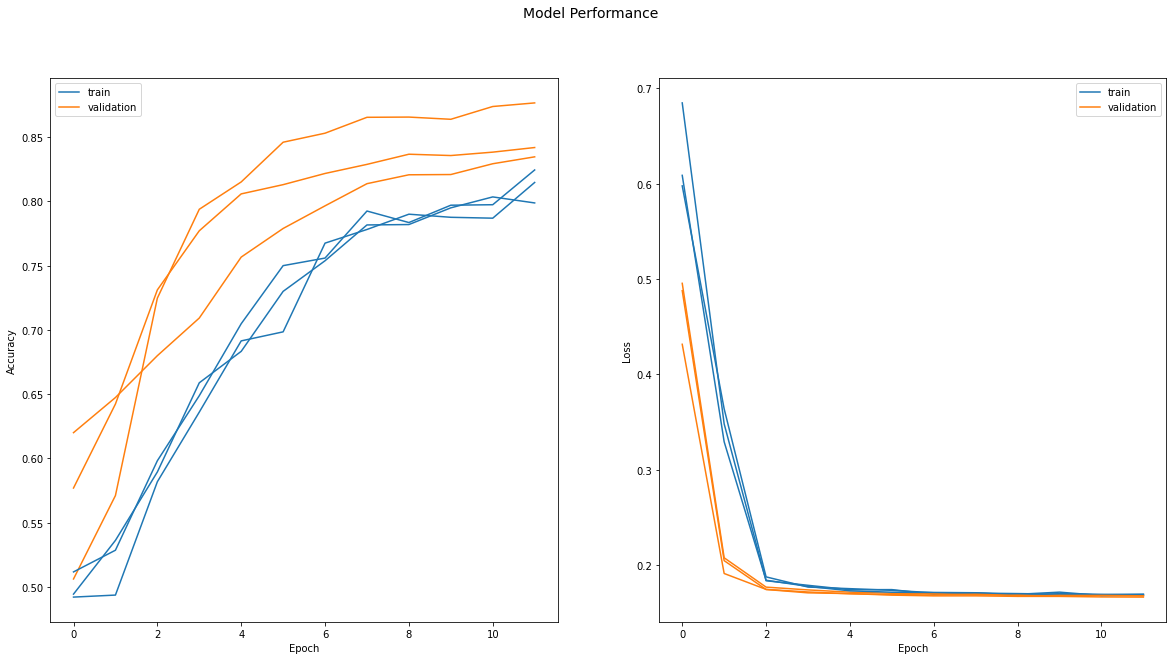

In [27]:
plot_learning_curves(histories)

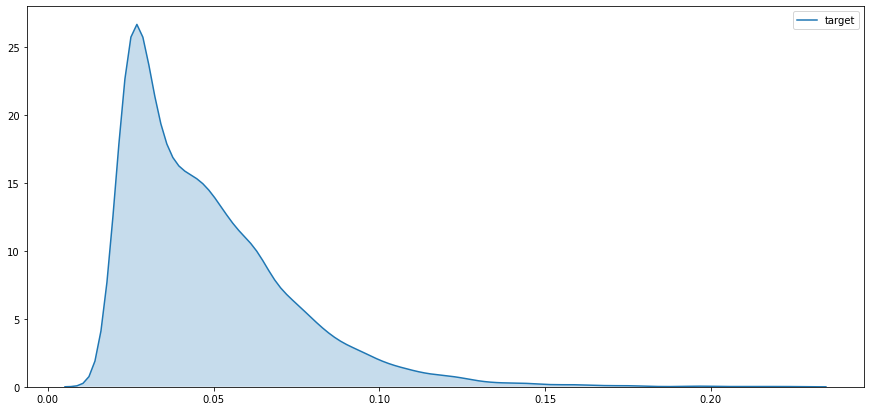

In [28]:
#okay last sanity check
fig, ax = plt.subplots(figsize = (15, 7))
sns.kdeplot(submission.target, shade = True)
plt.show()